In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn import metrics
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

#prep
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

#models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#validation libraries
from sklearn.cross_validation import KFold, StratifiedKFold

/Users/mariusmiron/anaconda/envs/bias/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
##Load datasets
with open('dat/dfmain.pkl', 'rb') as pickle_file:
    dfmain = pickle.load(pickle_file) 

In [3]:
df=dfmain[['recid','V65_@1_violencia_previa','V66_@2_historia_delictes_no_violents','V67_@3_inici_precoç_violencia',\
           'V68_@4_fracas_intervencions_anteriors','V69_@5_intents_autolesio_suicidi_anteriors','V70_@6_exposicio_violencia_llar',\
          'V71_@7_historia_maltracte_infantil','V72_@8_delinquencia_pares','V73_@9_separacio_precoç_pares',\
          'V74_@10_baix_rendiment_escola','V75_@11_delinquencia_grup_iguals','V76_@12_rebuig_grup_iguals',\
          'V77_@13_estrés_incapacitat_enfrontar_dificultats','V78_@14_escassa_habilitat_pares_educar','V79_@15_manca_suport_personal_social',\
          'V80_@16_entorn_marginal','V81_@17_actitud_negatives','V82_@18_assumpcio_riscos_impulsivitat',\
          'V83_@19_problemes_consum_toxics','V84_@20_problemes_maneig_enuig','V85_@21_baix_nivell_empatia_remordiment',\
          'V86_@22_problemes_concentracio_hiperactivitat','V87_@23_baixa_colaboracio_intervencions','V88_@24_baix_compromis_escolar_laboral']]

df.dropna(inplace=True)
df.replace(['Baix','Moderat','Alt'],[0,0.5,1],inplace=True)
df['recid'].replace(['Sí','No'],[1,0],inplace=True)
df.as_matrix()

/Users/mariusmiron/anaconda/envs/bias/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mariusmiron/anaconda/envs/bias/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/mariusmiron/anaconda/envs/bias/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

array([[1. , 1. , 0.5, ..., 1. , 0.5, 0.5],
       [1. , 1. , 0.5, ..., 0. , 0. , 0.5],
       [1. , 1. , 1. , ..., 0.5, 0.5, 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 1. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ]])

In [4]:
df = df.sample(frac=1, axis=1).reset_index(drop=True)
feature_cols = [col for col in df.columns if 'recid' not in col]
y = df['recid']
X = df[feature_cols]

In [5]:
X_cls_train, X_cls_valid, y_cls_train, y_cls_valid = train_test_split(X,y, test_size=0.2)
print(X_cls_train.shape, X_cls_valid.shape, y_cls_train.shape, y_cls_valid.shape)

(684, 24) (172, 24) (684,) (172,)


## Classification using logistic regression

When using clasification, or logistic regression, we can always get the predictions  .predict(usually 0, 1, 2 or discrete values). But there's a second function all .predict_logproba and .predict_proba with will give a [0,1] probability for every row. This is often used to rank predictions for classification scores (listed below)

why log prob vs. prob? Gradient methods generally work better optimizing logp(x)log⁡p(x) than p(x)p(x) because the gradient of logp(x)log⁡p(x) is generally more well-scaled. That is, it has a size that consistently and helpfully reflects the objective function's geometry, making it easier to select an appropriate step size and get to the optimum in fewer steps.

- .predict - gives 1's and 0's
- .predict_logproba - gives array of log probabilities, obs vs. classes
- .predict_proba - gives array of probabilities, obs vs. classes

In [6]:
lgm = LogisticRegression()
lgm.fit(X_cls_train,y_cls_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
lgm.score(X_cls_valid,y_cls_valid)

0.6511627906976745

In [8]:
lgm.score(X_cls_train,y_cls_train)

0.6491228070175439

In [9]:
y_lgm_p = lgm.predict(X_cls_train)
y_lgm_lpr = lgm.predict_log_proba(X_cls_train)
y_lgm_pr = lgm.predict_proba(X_cls_train)

y_lgm_lpr[:,0]
y_lgm_pr[:,0]
y_lgm_pr[:,1]
pd.DataFrame({'true': y_cls_train.values,
              'predict':y_lgm_p, 
              'log_prob_0':y_lgm_lpr[:,0],
              'log_prob_1':y_lgm_lpr[:,1],
              'prob_0': y_lgm_pr[:,0],
              'prob_1': y_lgm_pr[:,1]
             }).head(20)

,log_prob_0,log_prob_1,predict,prob_0,prob_1,true
0,-0.284955,-1.394521,0,0.752048,0.247952,0
1,-0.634199,-0.755789,0,0.530360,0.469640,0
2,-0.526947,-0.892586,0,0.590405,0.409595,0
3,-0.265018,-1.457543,0,0.767192,0.232808,0
4,-0.592395,-0.805199,0,0.553001,0.446999,1
5,-0.824033,-0.577427,1,0.438659,0.561341,0
6,-0.513767,-0.911895,0,0.598238,0.401762,1
7,-0.323158,-1.286844,0,0.723859,0.276141,0
8,-0.352505,-1.213771,0,0.702925,0.297075,0
9,-0.241865,-1.537873,0,0.785162,0.214838,0


.coef_ for linear models these are the coefficients that are assigned to your different features

Big impact not same as Better predictions A larger coefficient simple means it has a strong weight in calculating predictions, but that could lead to large error!

In [11]:
print(lgm.coef_)

[[ 0.00870733  0.31198791  0.3569487   0.18115016 -0.1000432   0.11154537
  -0.02481196 -0.00255487  0.24975471 -0.11437017  0.29418839  0.15037198
   0.11308357  0.12375745 -0.21523041 -0.41317466  0.42212898  0.14543811
  -0.22242826  0.32646719  0.18538772  0.06645622  0.61844732  0.03541324]]


## Generating a confusion matrix

Confusion matrix, without normalization
[[93 10]
 [50 19]]


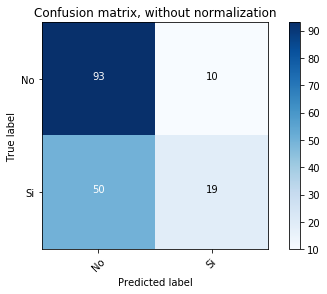

In [15]:
y_pred = lgm.predict(X_cls_valid)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = metrics.confusion_matrix(y_cls_valid, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No', 'Si'],
                      title='Confusion matrix, without normalization')

#### Sklearn metrics - good ones to know


- metrics.accuracy_score(y_true, y_pred[, …]) Accuracy classification score.
- metrics.auc(x, y[, reorder]) Compute Area Under the Curve (AUC) using the trapezoidal rule
- metrics.classification_report(y_true, y_pred) Build a text report showing the main classification metrics
- metrics.confusion_matrix(y_true, y_pred[, …]) Compute confusion matrix to evaluate the accuracy of a classification
- metrics.f1_score(y_true, y_pred[, labels, …]) Compute the F1 score, also known as balanced F-score or F-measure
- metrics.fbeta_score(y_true, y_pred, beta[, …]) Compute the F-beta score
- metrics.hinge_loss(y_true, pred_decision[, …]) Average hinge loss (non-regularized)
- metrics.log_loss(y_true, y_pred[, eps, …]) Log loss, aka logistic loss or cross-entropy loss.
- metrics.precision_recall_curve(y_true, …) Compute precision-recall pairs for different probability thresholds
- metrics.precision_recall_fscore_support(…) Compute precision, recall, F-measure and support for each class
- metrics.precision_score(y_true, y_pred[, …]) Compute the precision
- metrics.recall_score(y_true, y_pred[, …]) Compute the recall
- metrics.roc_auc_score(y_true, y_score[, …]) Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
- metrics.roc_curve(y_true, y_score[, …]) Compute Receiver operating characteristic (ROC)
- metrics.zero_one_loss(y_true, y_pred[, …]) Zero-one classification loss.

In [16]:
from sklearn.metrics import accuracy_score, auc, classification_report, \
confusion_matrix, f1_score, log_loss, precision_recall_curve, roc_auc_score, roc_curve

print('Log Loss: ', log_loss(y_lgm_p, y_cls_train))
print('Accuracy_score: ', accuracy_score(y_lgm_p, y_cls_train))
print('confusion_matrix: ', confusion_matrix(y_lgm_p, y_cls_train))
print('Classification_Report: ', classification_report(y_lgm_p, y_cls_train))

Log Loss:  12.119079330871346
Accuracy_score:  0.6491228070175439
confusion_matrix:  [[372 180]
 [ 60  72]]
Classification_Report:               precision    recall  f1-score   support

          0       0.86      0.67      0.76       552
          1       0.29      0.55      0.37       132

avg / total       0.75      0.65      0.68       684



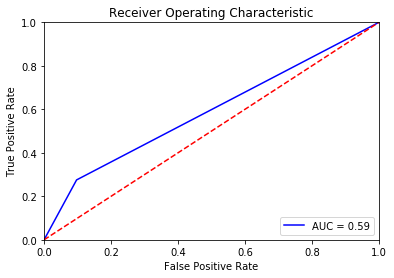

In [18]:
fpr, tpr, threshold = roc_curve(y_cls_valid, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


/Users/mariusmiron/anaconda/envs/bias/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


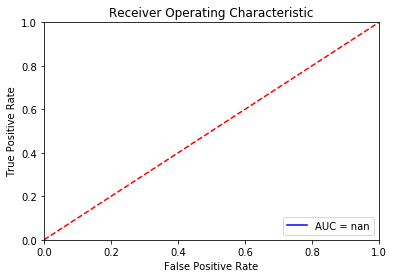

In [20]:
y_pred_true = lgm.predict(X_cls_valid[y_cls_valid==1])
fpr, tpr, threshold = roc_curve(y_cls_valid[y_cls_valid==1], y_pred_true)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Grid Search/Randomized Search: the quest for hyperparameters 


Look at how many options are in logistic regression:
   
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False)
             
Many of the advanced machine learning functions have a large number of model options that can be entered. these are often called hyper parameters. These address questions such as:

"how long should the model run", or
"how many times should my computer re-look at the data" or
"how slow should the computer work through the problem?"

To assist answering some of these questions, sklearn has GridSearch and RandomizedSearch which will try various combinations with a provided model, compare scores and return the optimal model that should be tried.

In [ ]:
rfr = RandomForestRegressor(n_jobs=-1)

Using GridSearch we can find the optimal parameters for Random forest 

In [ ]:
params = {
    'max_features': [0.25, 0.5, 0.7],
    'max_depth' : [ 2,5,10,20]
}
gs = GridSearchCV(cv=5, param_grid=params, estimator=rfr, verbose=0)
gs.fit(X_train,y_train)
print(gs.best_params_, gs.best_score_)

Using RandomSearch we can find the optimal parameters for Random forest 

In [ ]:
params = {
    'max_features': [0.25, 0.5, 0.7],
    'max_depth' : [ 2,5,10,20]
}
rs = RandomizedSearchCV(cv=5, param_distributions=params, estimator=rfr, verbose=0)
rs.fit(X_train,y_train)
print(rs.best_params_, rs.best_score_)